Práctica 2
# 1. Introducción al problema a solucionar
La práctica tiene como objetivo principal demostrar la comprensión y aplicación de los conceptos relacionados con el diseño y uso de redes neuronales, los cuales han sido explicados durante las sesiones presenciales de la asignatura. Para ello, se solicita la implementación y evaluación de al menos dos modelos basados en redes neuronales utilizando la biblioteca PyTorch.

El modelo debe resolver un problema específico relacionado con el conjunto de datos proporcionado: The Oxford-IIIT Pet Dataset. 
Para esta práctica se ha hecho uso de Google Colab debido a que algunos de los modelos requieren una tarjeta gráfica mejor.

Primero de todo importamos las librerías necesarias para la práctica.

## Importamos las librerias

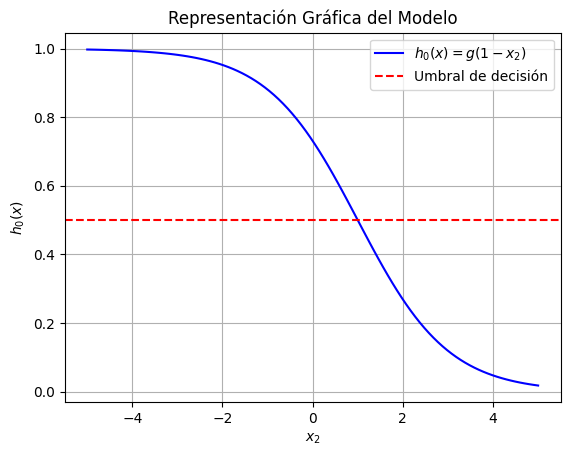

: 

In [3]:
import numpy as np
import matplotlib.pyplot as plt



Tenemos la carpeta de imágenes en el mismo directorio y una carpeta *annotations* con un archivo .txt donde se describe cada columna:
* Image 
* CLASS-ID: Class ids
* SPECIES: 1:Cat 2:Dog
* BREED ID: 1-25:Cat 1:12:Dog

In [13]:
images = 'images/'
annotations = 'annotations/list.txt'

# Leer el archivo y crear el DataFrame
with open(annotations, 'r') as file:
    lines = [line.split() for line in file if not line.startswith('#')]

cols = ["Image", "CLASS-ID", "SPECIES", "BREED ID"]
df = pd.DataFrame(lines, columns=cols)

# Concatenar la ruta de la imagen
df["Image"] = images + df["Image"] + '.jpg'

# Convertir columnas a tipo de datos adecuado
numeric_columns = ["CLASS-ID", "SPECIES", "BREED ID"]
df[numeric_columns] = df[numeric_columns].astype('int64')

df[numeric_columns] -= 1

print(df)


                                Image  CLASS-ID  SPECIES  BREED ID
0           images/Abyssinian_100.jpg         0        0         0
1           images/Abyssinian_101.jpg         0        0         0
2           images/Abyssinian_102.jpg         0        0         0
3           images/Abyssinian_103.jpg         0        0         0
4           images/Abyssinian_104.jpg         0        0         0
...                               ...       ...      ...       ...
7344  images/yorkshire_terrier_96.jpg        36        1        24
7345  images/yorkshire_terrier_97.jpg        36        1        24
7346  images/yorkshire_terrier_98.jpg        36        1        24
7347  images/yorkshire_terrier_99.jpg        36        1        24
7348   images/yorkshire_terrier_9.jpg        36        1        24

[7349 rows x 4 columns]


Mostramos las diferentes clases y como sabemos que nuestro conjunto de datos son imágenes de perros y gatos, vamos a mostrar la distribución de cada especie.

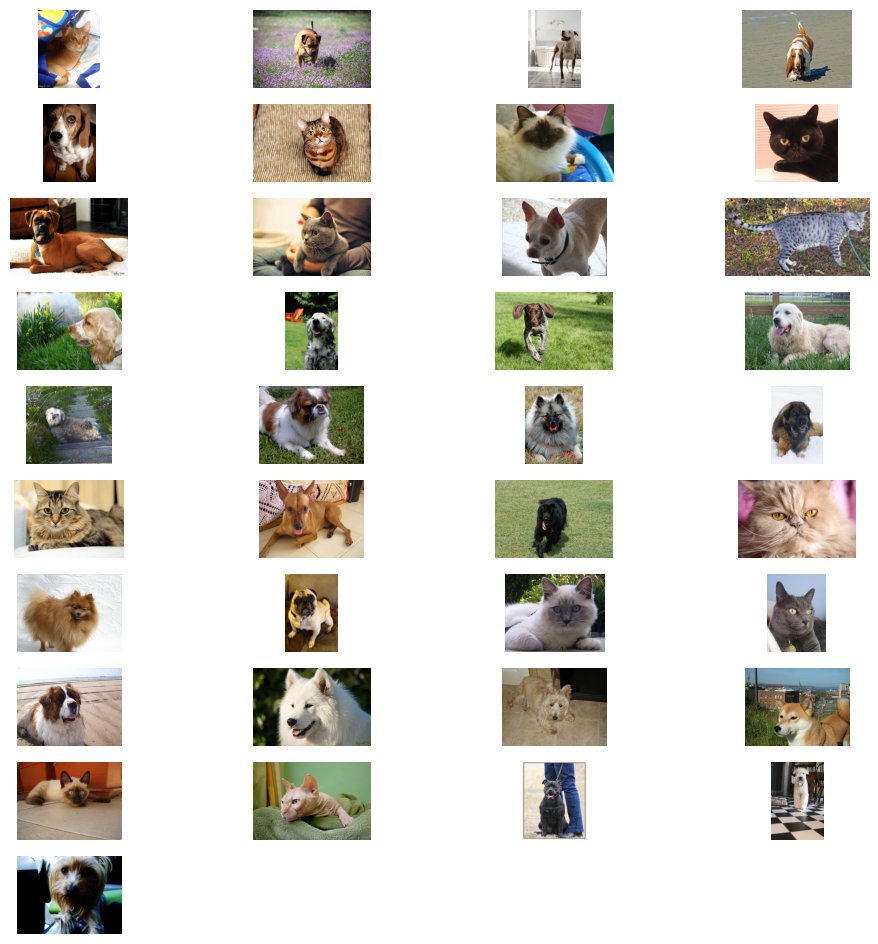

In [14]:
num_classes = len(df["CLASS-ID"].unique())
rows = num_classes // 4 + 1
cols = 4

plt.figure(figsize=(12, 12))

for i, class_id in enumerate(df["CLASS-ID"].unique()):
    class_sample = df[df["CLASS-ID"] == class_id].iloc[0]
    img = imread(class_sample["Image"])

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis('off')
plt.show()

C:\Users\alero\AppData\Local\Temp\ipykernel_14360\1956270645.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=species_counts.index, y=species_counts.values, palette="viridis")


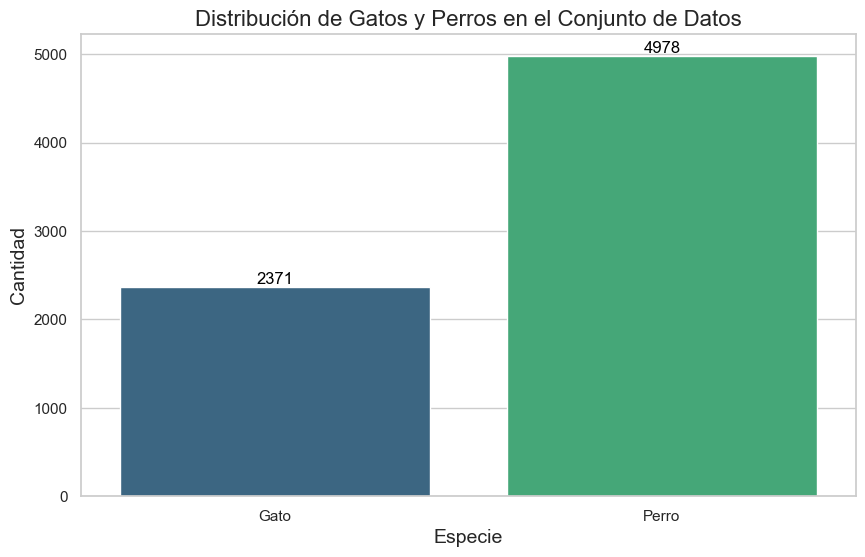

In [15]:
df["SPECIES"] = df["SPECIES"].map({0: "Gato", 1: "Perro"})


species_counts = df["SPECIES"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x=species_counts.index, y=species_counts.values, palette="viridis")

plt.title('Distribución de Gatos y Perros en el Conjunto de Datos', fontsize=16)
plt.xlabel('Especie', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)
plt.xticks(rotation=0)

for i, count in enumerate(species_counts.values):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=12, color='black')

plt.show()

# Clasificación perros vs gatos

Para la clasificación de perros vs gatos primero crearemos una red convolucional propia, crearemos una clase para el dataset. 

Los datos serán divididos en train y test reservándonos un 20% para las muestras de test y un 80% para el entrenamiento.

Ahora, vamos a crear nuestra red neuronal. Aplicando ReLU como función de activación.

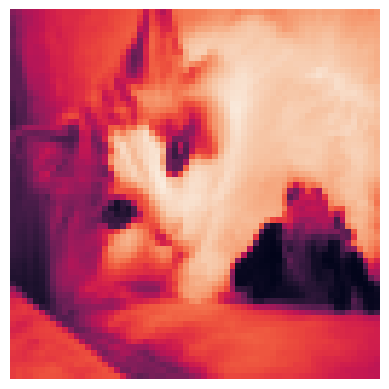

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from PIL import Image



X = df[["Image"]]
y = df[["SPECIES"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.paths = images 
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        path = self.paths.iloc[index]
        label = self.labels.iloc[index]

        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


train_dataset = CustomDataset(df_train['Image'], df_train['SPECIES'], transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(df_test['Image'], df_test['SPECIES'], transform)
test_loader = DataLoader(test_dataset, batch_size=32)

iterador =  iter(train_loader)

features, labels = next(iterador)

plt.imshow(features[0][0])
plt.axis("off")
plt.show()


Viendo como han quedado las imágenes, necesitaremos aplicar una técnica de aumento de datos y redimensionamiento.

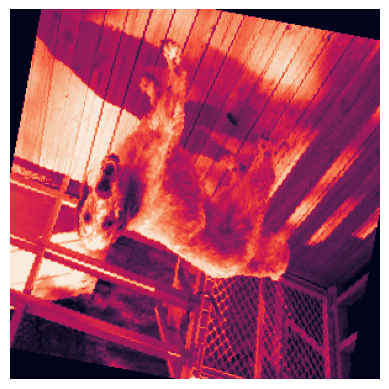

In [17]:
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = ConcatDataset([
    CustomDataset(df_train['Image'], df_train['SPECIES'], train_transform),
    CustomDataset(df_train['Image'], df_train['SPECIES'], train_transform)
])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(df_test['Image'], df_test['SPECIES'], test_transform)
test_loader = DataLoader(test_dataset, batch_size=32)

iterador =  iter(train_loader)

features, labels = next(iterador)

plt.imshow(features[0][0])
plt.axis("off")
plt.show()


Las imágenes se ven mejor ahora, vamos a crear nuestra red neuronal propia. 

In [18]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define una red neuronal simple para clasificar perros vs gatos
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 150 * 150, 128)  # Ajusta el tamaño de entrada
        self.fc2 = nn.Linear(128, 2)  # 2 clases: gato y perro

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 150 * 150)  # Ajusta el tamaño de entrada
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instancia el modelo y define la función de pérdida y el optimizador
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Ahora vamos a probar nuestra red neuronal con el conjunto d datos. 

  0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'to'